## Алгоритми класифікації: дерева рішень і випадковий ліс  

Банк розглядає заявки від потенційних клієнтів, які хочуть отримати кредит. Для банку важливо зрозуміти:  
- чи зможе клієнт повернути кредит у повному обсязі,  
- чи існує ризик, що він не виконає свої зобов’язання.  

Якщо банк прийме неправильне рішення:  
- видасть кредит ненадійній особі → отримає збитки,  
- відмовить надійному клієнту → втратить потенційний прибуток.
  
Тому побудова моделей, які прогнозують статус повернення кредиту, є економічно значущим завданням.

Для прикладу використаємо набір даних про 32 581 позичальника банку:

In [3]:
#імпортуємо необхідні бібліотеки
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# зчитаємо файл з початковими даними в датафрейм data
df = pd.read_csv('credit_default.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Кожний рядок у таблиці – це інформація про одного клієнта. Змінні:  
person_age – вік позичальника  
person_income – річний дохід  
person_home_ownership – житловий статус (оренда, іпотека, власне житло)  
person_emp_length – стаж роботи  
loan_intent – мета кредиту (навчання, лікування, бізнес тощо)  
loan_grade – кредитний рейтинг (A–G, де A-клієнт із найвищим рейтингом, G - найнижчим)  
loan_amnt – розмір кредиту  
loan_int_rate – відсоткова ставка  
loan_percent_income – частка кредиту від доходу  
cb_person_default_on_file – наявність прострочених боргів у минулому  
cb_person_cred_hist_length – тривалість кредитної історії  
loan_status – цільова змінна:  
0 – кредит сплачено  
1 – кредит не сплачено  
Саме loan_status ми будемо намагатися передбачити.  

Традиційно рішення може приймати банківський службовець, який аналізує інформацію про кожного позичальника: його вік, дохід, кредитну історію тощо. Проте такий підхід має суттєві недоліки:  
- він суб’єктивний,  
- потребує багато часу,  
- важко врахувати всі можливі фактори одночасно.  

В таких випадках на допомогу приходить машинне навчання: ми можемо використати історичні дані про клієнтів (тих, хто вже отримував кредити) і побудувати модель, яка навчиться розпізнавати закономірності та зможе автоматично приймати рішення для нових позичальників.

### Задачі класифікації  
Коли ми маємо набір змінних (вік, дохід, кредитна історія тощо), і хочемо передбачити категоріальний результат на основі цього набору (наприклад: «сплатив» або «не сплатив» кредит), – це називається задачею класифікації.  
**Особливості задач класифікації:**  
- Цільова змінна (залежна змінна, результат) – категорія, а не число. Наприклад: 0 / 1, «так» / «ні», «ризиковий» / «надійний».  
- Модель навчається на історичних даних: ми показуємо їй приклади клієнтів, які вже або повернули кредит, або ні.  
- Далі модель може прогнозувати для нових клієнтів.

**Практичні приклади задач класифікації**

Задачі класифікації зустрічаються дуже часто, особливо там, де потрібно приймати рішення на основі великої кількості факторів.

Приклади в економіці:

- Виявлення шахрайських транзакцій  
Банки й платіжні системи щосекунди обробляють мільйони операцій. Модель може аналізувати характер транзакцій: час, суму, місце проведення, історію попередніх покупок клієнта. Якщо операція виглядає підозріло (наприклад, одночасні покупки з різних країн), система автоматично відмічає її як потенційне шахрайство. Це допомагає швидко реагувати та зменшити втрати.

- Визначення групи ризику страхувальника  
У страхових компаніях важливо оцінити ризик клієнта. Наприклад, при оформленні автострахування модель може враховувати вік водія, стаж керування, історію ДТП, марку автомобіля тощо. В результаті клієнтів поділяють на групи: "низький ризик", "середній ризик", "високий ризик", і саме від цього залежатиме розмір страхової премії.


Приклади поза економікою:

- Медицина: діагностика захворювань  
На основі аналізів крові, результатів МРТ, симптомів та інших даних модель може класифікувати, чи є у пацієнта певне захворювання. Це допомагає лікарям швидше та точніше ставити діагнози.

- Розпізнавання зображень  
Системи комп’ютерного зору класифікують фотографії: "кіт" чи "собака", "автомобіль" чи "велосипед". Це використовується у безпілотних авто, системах безпеки, соціальних мережах (наприклад, автоматичне визначення облич на фото).

- Фільтрація електронної пошти  
Модель аналізує текст і метадані повідомлення, класифікуючи його як "спам" чи "не спам". Це допомагає користувачам не отримувати небажані листи у головній скриньці.

### Приклад реалізації алгоритму класифікації за допомогою бібліотеки Scikit Learn    
  
#### Що варто зробити до реалізації алгоритму класифікації? 
Подивитися на датасет: .head (), .info (), .describe ()   
Проаналізувати викиди в даних, за потреби - видалити їх  
**ОБОВ'ЯЗКОВО: Почистити від пропущених значень**   
**ОБОВ'ЯЗКОВО: Перекодувати стовпчики із категоріальними даними (інформація подана у вигляді тексту)**  

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


#### Опрацюємо викиди в даних

In [10]:
# перевіримо наявність викидів
def extreme_values_summary(df):
    """
    Для кожної числової колонки виводить:
    - мінімум
    - 1% процентиль
    - 99% процентиль
    - максимум
        """
    num_cols = df.select_dtypes(include=[np.number]).columns #відбираємо тільки числові змінні
    summary = {}

# в кожному стовпчику видаляємо пропуски, розраховуємо 1%-ий та 99%-ий процентилі
    for col in num_cols:
        col_data = df[col].dropna()
        q01 = col_data.quantile(0.01)
        q99 = col_data.quantile(0.99)
        

# зводимо разом результати, отримані для кожного стовпчика 
        summary[col] = {
            "min": col_data.min(),
            "1%": q01,
            "99%": q99,
            "max": col_data.max(),
                    }

    return pd.DataFrame(summary).T

extreme_values_summary(df) #виклик функції

,min,1%,99%,max
person_age,20.00,21.00,50.00,144.00
person_income,4000.00,14400.00,225200.00,6000000.00
person_emp_length,0.00,0.00,18.00,123.00
loan_amnt,500.00,1000.00,29800.00,35000.00
loan_int_rate,5.42,5.42,18.62,23.22
loan_status,0.00,0.00,1.00,1.00
loan_percent_income,0.00,0.02,0.50,0.83
cb_person_cred_hist_length,2.00,2.00,17.00,30.00


In [11]:
#видалимо 1% найменших та найбільших значень
df_cleaned = df.copy()

# Вибираємо кількісні змінні (числові стовпці)
numeric_columns = df.select_dtypes(include=[float, int]).columns

for col in numeric_columns:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    
    # Фільтрація з урахуванням NaN
    df_cleaned = df_cleaned[
        ((df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)) | (df_cleaned[col].isna())
    ]
    
    print(f"Кількість рядків після видалення викидів у колонці {col}: {df_cleaned.shape[0]}")

# Переглянемо результат
df_cleaned.describe()

Кількість рядків після видалення викидів у колонці person_age: 32278
Кількість рядків після видалення викидів у колонці person_income: 31647
Кількість рядків після видалення викидів у колонці person_emp_length: 31457
Кількість рядків після видалення викидів у колонці loan_amnt: 31176
Кількість рядків після видалення викидів у колонці loan_int_rate: 30926
Кількість рядків після видалення викидів у колонці loan_status: 30926
Кількість рядків після видалення викидів у колонці loan_percent_income: 30622
Кількість рядків після видалення викидів у колонці cb_person_cred_hist_length: 30622


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,30622.000000,30622.000000,29819.000000,30622.000000,27668.000000,30622.000000,30622.000000,30622.000000
mean,27.351806,62626.413983,4.663235,9281.879041,10.905127,0.203840,0.166678,5.577003
std,5.457589,33431.982312,3.767464,5738.588638,3.136562,0.402858,0.099414,3.631538
min,21.000000,14400.000000,0.000000,1000.000000,5.420000,0.000000,0.020000,2.000000
25%,23.000000,39000.000000,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,55000.000000,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,77936.750000,7.000000,12000.000000,13.240000,0.000000,0.220000,8.000000
max,50.000000,225000.000000,18.000000,29800.000000,18.620000,1.000000,0.500000,17.000000


In [12]:
#повертаюся до назви датафрейму df
df = df_cleaned.copy()

#### Опрацюємо пропуски в даних

In [14]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              803
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2954
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [15]:
#видалимо всі пропуски в даних
df.dropna(inplace=True)

##### Визначимо матрицю незалежних змінних (факторів) та вектор цільової (залежної) змінної

In [17]:
X = df.drop(columns=['loan_status'], axis=1) # Незалежні змінні(фактори)
y = df['loan_status']  # Цільова змінна

#### Перекодуємо категоріальні дані

In [19]:
from sklearn.preprocessing import OneHotEncoder

# Вибираємо категоріальні стовпці
categorical_columns = X.select_dtypes(include=['object']).columns

# Ініціалізуємо OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Застосовуємо OneHotEncoder до категоріальних стовпців
encoded_columns = encoder.fit_transform(X[categorical_columns])

# Створюємо новий DataFrame з перекодованими змінними і назвами колонок
encoded_X = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Переконаємося, що індекси X і encoded_X співпадають
encoded_X.index = X.index

# Видаляємо оригінальні категоріальні стовпці
X = X.drop(columns=categorical_columns)

# Об'єднуємо початковий DataFrame з новими перекодованими стовпцями
X = pd.concat([X, encoded_X], axis=1)

# Перевіряємо результати
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 26928 entries, 63 to 32296
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   26928 non-null  int64  
 1   person_income                26928 non-null  int64  
 2   person_emp_length            26928 non-null  float64
 3   loan_amnt                    26928 non-null  int64  
 4   loan_int_rate                26928 non-null  float64
 5   loan_percent_income          26928 non-null  float64
 6   cb_person_cred_hist_length   26928 non-null  int64  
 7   person_home_ownership_OTHER  26928 non-null  float64
 8   person_home_ownership_OWN    26928 non-null  float64
 9   person_home_ownership_RENT   26928 non-null  float64
 10  loan_intent_EDUCATION        26928 non-null  float64
 11  loan_intent_HOMEIMPROVEMENT  26928 non-null  float64
 12  loan_intent_MEDICAL          26928 non-null  float64
 13  loan_intent_PERSONAL

#### Розділення даних на навчальну і тестову вибірки  
Навчальну вибірку використовуємо для навчання моделі  
Тестову вибірку використовуємо для перевірки якості побудованої моделі  

In [21]:
# імпортуємо train_test_split із модуля sklearn.model_selection
from sklearn.model_selection import train_test_split

#Розділимо дані на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

- параметр stratify = y означає, що метод train_test_split повертає навчальні та тестові вибірки, які мають ті самі пропорції міток класів, що й набір вхідних даних. Наприклад, якщо цільова змінна y є бінарною змінною зі значеннями 0 або 1 і  містить 40% нулів і 60 % одиниць, то параметр stratify=y гарантуватиме, що при розбитті даних навчальна та тестова вибірка також міститимуть 40% нулів і 60 % одиниць.  
- параметр test_size визначає розмір тестової вибірки. Як правило, test_size приймають рівним 0.2 або 0.3 (відповідно 20% та 30% від набору вхідних даних).  
- параметр random_state (йому можна присвоїти будь-яке число, необов'язково 0) гарантує, що ви отримуєте те саме розбиття на навчальну та тестову вибірки кожного разу, коли ви запускаєте свій код. 

#### Навчання моделей класифікації  
У задачах класифікації існує багато алгоритмів: логістична регресія, дерева рішень, випадковий ліс, метод опорних векторів, нейронні мережі тощо.
У цій лекції зосередимося на дереві рішень та випадковому лісі:
- Дерево рішень — простий і зрозумілий алгоритм, його легко пояснити й інтерпретувати.  
- Випадковий ліс — ансамбль з багатьох дерев, дає більш точні прогнози та менше схильний до помилок через перенавчання.

**Суть методу дерева рішень**  
Дерево рішень (Decision Tree) працює як серія запитань:  
1. Спочатку воно вибирає ознаку, яка найкраще розділяє дані на групи.  
2. Далі на кожній гілці знову перевіряє іншу ознаку, що уточнює рішення.  
3. У кінцевих вузлах (листках) ми отримуємо прогноз: наприклад, "кредит буде сплачено" або "кредит не буде сплачено".  

In [24]:
# Щоб проілюструвати принцип роботу алгоритму побудуємо коротке дерево рішень 
# Зараз код подано у вигляді коментаря, для запуску коду необхідно прибрати ''' напочатку та наприкінці коду
'''from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Створюємо дерево з невеликою глибиною для наочності
small_tree = DecisionTreeClassifier(max_depth=2, random_state=0)
small_tree.fit(X_train, y_train)

plt.figure(figsize=(16,8))
plot_tree(
    small_tree, 
    feature_names=X_train.columns, 
    class_names=["Сплачено", "Не сплачено"], 
    filled=True, rounded=True, fontsize=10
)
plt.title("Приклад дерева рішень (глибина = 2)")
plt.show()'''


'from sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\n\n# Створюємо дерево з невеликою глибиною для наочності\nsmall_tree = DecisionTreeClassifier(max_depth=2, random_state=0)\nsmall_tree.fit(X_train, y_train)\n\nplt.figure(figsize=(16,8))\nplot_tree(\n    small_tree, \n    feature_names=X_train.columns, \n    class_names=["Сплачено", "Не сплачено"], \n    filled=True, rounded=True, fontsize=10\n)\nplt.title("Приклад дерева рішень (глибина = 2)")\nplt.show()'

### Загальна схема навчання всіх моделей класифікації із використанням бібліотеки scikit-learn (на прикладі дерева рішень)
1. Імпортуємо необхідні бібліотеки  
DecisionTreeClassifier – сам алгоритм (дерево рішень).  
accuracy_score, confusion_matrix – метрики для оцінки якості моделі.  
2. Створюємо класифікатор (модель)  
dt_model = DecisionTreeClassifier(max_depth=5, random_state=0)  
На цьому етапі за потреби задаємо гіперпараметри (наприклад, глибину дерева).  
3. Навчаємо модель за допомогою методу .fit() **на навчальному наборі даних**      
dt_model.fit(X_train, y_train)  
Модель отримує навчальні дані (X_train) та правильні відповіді (y_train), і на їх основі будує дерево правил.  
4. Робимо прогноз  за допомогою методу .predict() **на тестовому наборі даних**  
y_pred = dt_model.predict(X_test)
Тепер ми передаємо у модель тестові дані, і вона видає прогноз: для кожного клієнта визначає, чи він поверне кредит.
5. Оцінюємо точність  
наприклад, для моделей класифікації це може бути точність класифікації та матриця помилок  
accuracy_score(y_test, y_pred) показує частку правильних відповідей моделі.
confusion_matrix(y_test, y_pred) матриця помилок показує, скільки клієнтів правильно/неправильно віднесено до класів "сплатив" і "не сплатив".

In [26]:
#Реалізуємо алгоритм дерева рішень
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Створюємо модель дерева рішень
dt_model = DecisionTreeClassifier(max_depth=5, random_state=0)

# Навчаємо модель
dt_model.fit(X_train, y_train)

# Прогнозуємо на тестових даних
y_pred = dt_model.predict(X_test)

# Оцінка точності
print("Точність класифікації на тестових даних:", accuracy_score(y_test, y_pred))

# Матриця помилок
print("\nМатриця помилок:")
print(confusion_matrix(y_test, y_pred))

Точність класифікації на тестових даних: 0.9118083921277386

Матриця помилок:
[[4231   62]
 [ 413  680]]


#### Оцінка точності  класифікації та матриця помилок  
Далі необхідно оцінити якість класифікатора. Це можна зробити за допомогою основних метрик оцінювання точності класифікації та матриці помилок.  
**Точність класифікації (accuracy score)**. Accuracy score класифікатора вимірюється як частка спостережень, які були правильно класифіковані: 
$$Accuracy = (TP+TN)/(TP + FP + FN + TN)$$  
І навпаки, помилка класифікації визначається як частка спостережень, які були неправильно класифіковані.  

**Матриця помилок**    
Матриця 2x2, що позначає правильні та неправильні передбачення, може допомогти нам проаналізувати точність класифікації. Ця матриця називається матрицею помилок.  
$$
\begin{array}{c|c|c}
 & \text{Predicted 0} & \text{Predicted 1} \\
\hline
\text{Actual 0} & TN & FP \\
\text{Actual 1} & FN & TP \\
\end{array}
$$
  

Стовпці відповідають прогнозованим значенням (y-predicted), а рядки - фактичним значенням (y-actual).

TN представляє значення, які спрогнозовані як хибні та насправді є хибними.  
FP представляє значення, які спрогнозовані як істинні, але є хибними.  
FN представляє значення, які спрогнозовані як хибні, але є істинними.  
TP представляє значення, які спрогнозовані як істинні та насправді є істинними.  

<span style="color:red"> **Висновок**</span>  
Точність моделі: ≈ 91% – це означає, що у 91% випадків модель правильно визначає статус кредиту.  
Матриця помилок:  
4231 клієнтів правильно віднесено до тих, хто сплатив кредит,  
680 клієнтів правильно класифіковано як тих, хто не сплатив,  
62 надійних клієнтів помилково віднесено до ненадійних,  
413 ризикових клієнтів модель віднесла до надійних.  

Отже: модель класифікує з високою точністю, однак важливо звернути увагу на 413 випадків, де ризикові клієнти потрапили у категорію надійних — для банку це може бути критично, адже саме такі помилки ведуть до фінансових втрат.

### Важливість ознак  
Важливість ознак (feature importance) показує, які змінні найбільше вплинули на роботу моделі.
У випадку дерева рішень:  
Коли модель приймає рішення, вона на кожному кроці вибирає ознаку, яка найкраще розділяє клієнтів на групи.  
Чим частіше і «сильніше» ознака використовується для поділів, тим більша її важливість.  

**Як інтерпретувати важливість ознак:**  
- Кожна ознака отримує вагу важливості — число між 0 і 1.  
- Це число показує, яку частку в побудові дерева внесла ця ознака.  
- Чим більше значення, тим більший вплив ознаки на кінцевий прогноз.  
- Усі значення нормуються так, щоб у сумі давали 1.  

Таким чином, для даних про позичальників банку аналіз важливості ознак допомагає банку зрозуміти, які фактори найбільше визначають ймовірність повернення кредиту (наприклад, дохід, відсоткова ставка чи кредитна історія).

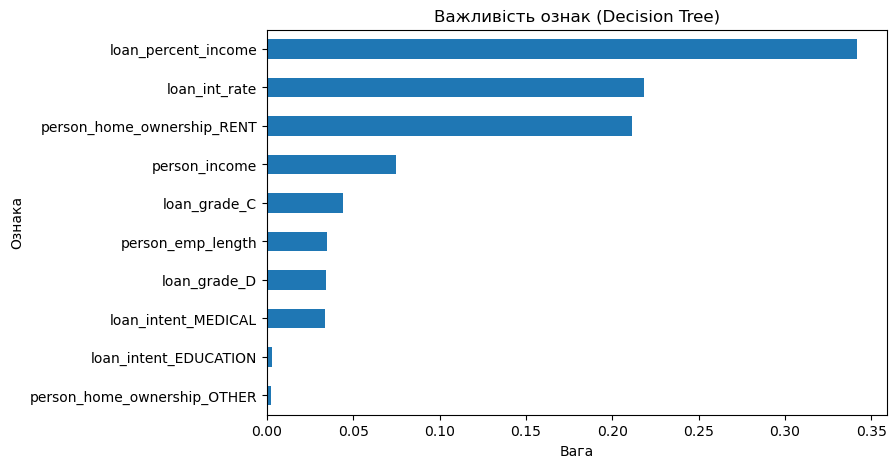

In [30]:
# Важливість ознак для дерева рішень
feature_importance_dt = pd.Series(dt_model.feature_importances_, index=X_train.columns)

# Візуалізація
import matplotlib.pyplot as plt

# Топ-10 важливих ознак
top_features = feature_importance_dt.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_features.plot(kind='barh')   # горизонтальний графік
plt.title("Важливість ознак (Decision Tree)")
plt.xlabel("Вага")             
plt.ylabel("Ознака")
plt.gca().invert_yaxis()        
plt.show()


Найбільший вплив на рішення моделі має частка кредиту від доходу (loan_percent_income) – логічно, адже чим більший платіж у порівнянні з доходом, тим вищий ризик неповернення. Значний внесок також роблять відсоткова ставка по кредиту (loan_int_rate) та статус житла «оренда» person_home_ownership_RENT) – клієнти з високими % ставками і без власного житла є ризиковішими. Інші фактори, такі як дохід, кредитний рейтинг (C, D),  також впливають, але меншою мірою.

Аналогічно навчимо та перевіримо якість моделі випадкового лісу

**Принцип роботи випадкового лісу**  
Випадковий ліс (Random Forest) – це ансамбль із багатьох дерев рішень (як колективне рішення комісії замість думки однієї людини):    
- Кожне дерево будується на випадковій підмножині даних і випадковому наборі ознак.  
- Для нового клієнта усі дерева роблять свій прогноз, а фінальне рішення приймається більшістю голосів.  

Такий підхід дозволяє отримати більш точний і стабільний результат, ніж у випадку одного дерева.

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Створюємо модель випадкового лісу
rf_model = RandomForestClassifier(
    n_estimators=100,   # кількість дерев
    max_depth=None,     # глибина дерев (None - рости до кінця)
    random_state=0
)

# Навчання моделі
rf_model.fit(X_train, y_train)

# Прогноз на тестових даних
y_pred_rf = rf_model.predict(X_test)

# Оцінка точності
print("Точність на тестових даних:", accuracy_score(y_test, y_pred_rf))

# Матриця помилок
print("\nМатриця помилок:")
print(confusion_matrix(y_test, y_pred_rf))

Точність на тестових даних: 0.935573709617527

Матриця помилок:
[[4266   27]
 [ 320  773]]


<span style="color:red"> **Висновок**</span>  
Точність моделі склала приблизно 93,6%, що є трохи вищим показником, ніж у дерева рішень (~91,2%). Це означає, що випадковий ліс класифікує клієнтів точніше.  

Матриця помилок:  
4266 клієнтів правильно класифіковано як тих, хто сплатив кредит,  
773 клієнти правильно визначені як ті, що не сплатили,  
Лише 27 випадків, коли надійних клієнтів віднесли до ненадійних,  
320 випадків, коли ризикових клієнтів помилково віднесли до надійних.  

Отже, у порівнянні з деревом рішень, модель випадкового лісу показала кращий результат, зменшивши кількість помилок у прогнозуванні. Це підтверджує, що використання ансамблю дерев робить прогнозування стабільнішим і надійнішим.

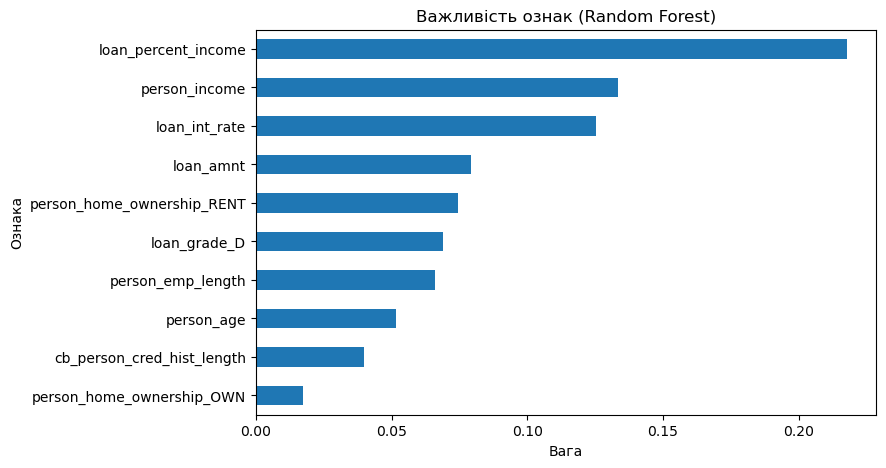

In [35]:
# Важливість ознак для випадкового лісу
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Візуалізація
import matplotlib.pyplot as plt

# Топ-10 важливих ознак
top_features = feature_importance_rf.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_features.plot(kind='barh')   # горизонтальний графік
plt.title("Важливість ознак (Random Forest)")
plt.xlabel("Вага")             
plt.ylabel("Ознака")
plt.gca().invert_yaxis()        
plt.show()

Найбільший вплив знову має частка кредиту від доходу (loan_percent_income) – це підтверджує, що саме цей показник є ключовим для прогнозу. Важливу роль також відіграють дохід клієнта (person_income), відсоткова ставка (loan_int_rate) та розмір кредиту (loan_amnt). Інші фактори, як-от житловий статус, вік, кредитний рейтинг та тривалість кредитної історії, також враховуються, але мають менший вплив.

Порівняння важливості ознак обох моделей: у дереві рішень головними були loan_percent_income і loan_int_rate, тоді як у випадковому лісі більш рівномірно враховуються ще й дохід та сума кредиту, що робить модель більш збалансованою.

### Прогноз для нових позичальників  

Навчену модель випадкового лісу можемо використати для прийняття рішень щодо видачі кредитів новим клієнтам. Модель отримує дані про потенційного позичальника (вік, дохід, розмір кредиту, кредитна історія тощо). На основі цих факторів вона прогнозує статус кредиту – чи буде він сплачений, чи є ризик неповернення.  
У практичному сенсі це означає, що модель допомагає банку прийняти рішення про видачу кредиту:
- якщо прогноз позитивний → клієнт імовірно поверне кредит,  
- якщо прогноз негативний → клієнт ризиковий, банк може відмовити.

In [38]:
# зчитаємо інформацію про нових позичальників в датафрейм
new_borrowers = pd.read_csv('new_borrowers.csv')
new_borrowers.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,30,76404,14.0,12000,6.540000,0.16,5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,25992,6.0,3000,9.450000,0.12,3,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,20245,5.0,3550,12.452941,0.18,4,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32,42000,0.0,8400,7.880000,0.20,9,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25,42348,9.0,8000,12.452941,0.19,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#для зручності дані вже підготовлені (пропусків/викидів немає, категоріальні змінні перекодовано)
new_borrowers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   19 non-null     int64  
 1   person_income                19 non-null     int64  
 2   person_emp_length            19 non-null     float64
 3   loan_amnt                    19 non-null     int64  
 4   loan_int_rate                19 non-null     float64
 5   loan_percent_income          19 non-null     float64
 6   cb_person_cred_hist_length   19 non-null     int64  
 7   person_home_ownership_OTHER  19 non-null     float64
 8   person_home_ownership_OWN    19 non-null     float64
 9   person_home_ownership_RENT   19 non-null     float64
 10  loan_intent_EDUCATION        19 non-null     float64
 11  loan_intent_HOMEIMPROVEMENT  19 non-null     float64
 12  loan_intent_MEDICAL          19 non-null     float64
 13  loan_intent_PERSONAL  

In [40]:
# Використовуємо навчену модель випадкового лісу для прогнозування
y_pred_new = rf_model.predict(new_borrowers)

# Додаємо прогнозовані значення до датафрейму new_borrowers
new_borrowers['Predicted'] = y_pred_new
new_borrowers

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,Predicted
0,30,76404,14.0,12000,6.540000,0.16,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,22,25992,6.0,3000,9.450000,0.12,3,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,21,20245,5.0,3550,12.452941,0.18,4,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,32,42000,0.0,8400,7.880000,0.20,9,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,25,42348,9.0,8000,12.452941,0.19,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,23,92000,0.0,6500,8.000000,0.07,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,26,180000,0.0,10000,8.000000,0.06,4,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,23,30000,4.0,8000,12.180000,0.27,2,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,25,80000,5.0,18200,7.900000,0.23,2,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,23,100000,4.0,25000,17.140000,0.25,2,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


Позичальникам 14, 16, 17, 18 рекомендовано відмовити у видачі кредиту, решті - видати кредит